In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn

from torch.optim import Adam, SGD

from time import time

In [5]:
import matplotlib.pyplot as plt

In [6]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable

if find_executable('latex'):
    plt.rc('text', usetex=True)
else:
    print('LaTeX not found...')

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [7]:
from models import estimators

In [8]:
from base import samplers

# Samplers

In [9]:
uniform = samplers.distribution2

In [10]:
gaussian = samplers.distribution3

In [11]:
f = torch.tensor(next(uniform()), dtype=torch.float)

In [12]:
g = torch.tensor(np.concatenate((next(gaussian()), next(gaussian())), axis=1))

In [13]:
f.size()

torch.Size([512, 2])

In [14]:
def generate(n=20, batch_size=512):
    
    for _ in range(n):
        
        f = torch.tensor(next(uniform(batch_size))[:, [0]], dtype=torch.float)
        g = torch.tensor(next(gaussian(batch_size)), dtype=torch.float)
        
        yield f, g

# Estimators

## Jensen-Shannon

In [15]:
js = estimators.JensenShannon(input_dimension=1)

In [16]:
optimiser = Adam(js.parameters(), lr=.001)

In [17]:
losses = []
distances = []

for f, g in generate(2000):
    
    js.zero_grad()
    
    loss = js.loss(f, g)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    distances.append(js.distance(f, g).item())
    
losses = np.array(losses)
distances = np.array(distances)

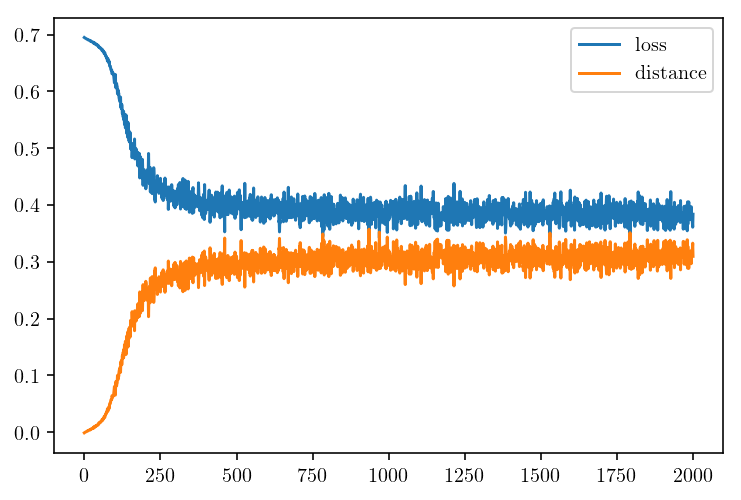

In [18]:
plt.figure()
plt.plot(losses, label='loss')
plt.plot(distances, label='distance')
plt.legend()
plt.show()

## Wasserstein

In [169]:
wasserstein = estimators.Wasserstein(input_dimension=1, hidden_dimension=20, kappa=10)

In [170]:
optimiser = Adam(wasserstein.parameters(), lr=.001)

In [171]:
losses = []
distances = []

for f, g in generate(2000):
    
    wasserstein.zero_grad()
    
    loss = wasserstein.loss(f, g, penalised=True)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    distances.append(wasserstein.distance(f, g).item())
    
losses = np.array(losses)
distances = np.array(distances)

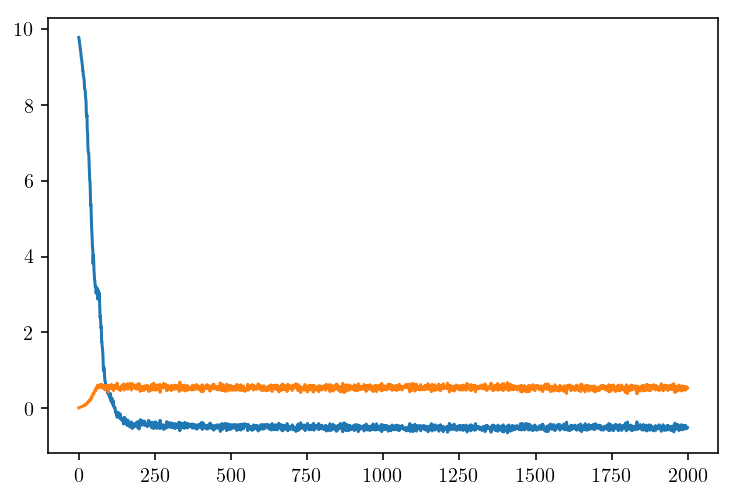

In [172]:
plt.figure()
plt.plot(losses)
plt.plot(distances)
plt.show()

# Estimating distances

## Jensen-Shannon

In [177]:
phis = np.linspace(-1, 1, 21)

In [178]:
phis

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [189]:
def estimate_jsd(phi, steps=100):
    js = estimators.JensenShannon(input_dimension=2)
    optimiser = Adam(js.parameters(), lr=.001)
    
    for step in range(steps):
        
        f = torch.tensor(next(samplers.distribution1(0)), dtype=torch.float)
        g = torch.tensor(next(samplers.distribution1(phi)), dtype=torch.float)
    
        js.zero_grad()

        loss = js.loss(f, g)
        loss.backward()

        optimiser.step()
        
    f = torch.tensor(next(samplers.distribution1(0)), dtype=torch.float)
    g = torch.tensor(next(samplers.distribution1(phi)), dtype=torch.float)
    
    return js.distance(f, g).item()

In [191]:
estimate_jsd(.9, steps=500)

0.6924077272415161

In [198]:
results = np.array([estimate_jsd(phi, steps=500) for phi in phis])

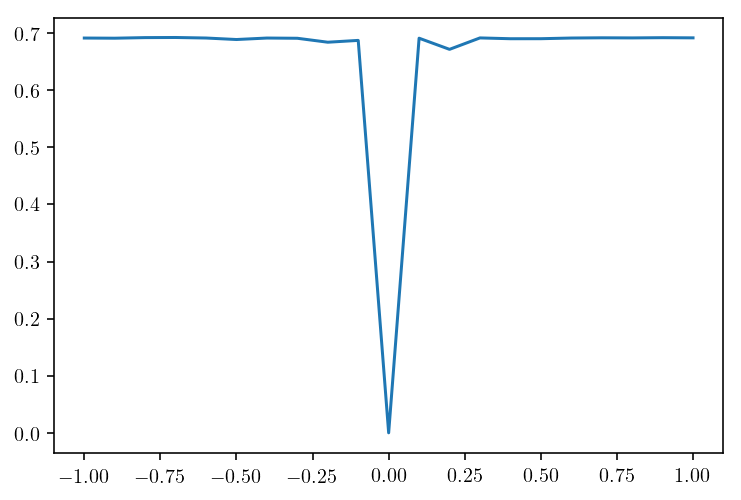

In [199]:
plt.plot(phis, results)